# 개요

- 출처
  - 원본 데이터 셋
    - [Paris Housing Price Prediction](https://www.kaggle.com/datasets/mssmartypants/paris-housing-price-prediction)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 내용 : 교육 목적, 실습 및 필요한 지식 습득을 위한  파리의 가상 집값 데이터에서 생성된 데이터 셋
- 평가지표 : RMSE 
- 타임라인 : 2023.2.7 ~ 2023.2.20

## 데이터 준비 및 확인

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
# 기본 패키지 도구 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
# from sklearn.metrics import cohen_kappa_score, confusion_matrix,ConfusionMatrixDisplay
from xgboost import XGBRegressor

In [158]:
train = pd.read_csv('/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/train.csv')
test = pd.read_csv('/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/test.csv')
origin = pd.read_csv('/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/ParisHousing.csv')
submission = pd.read_csv('/content/drive/MyDrive/모듈프젝2/A팀-회귀/data/playground-series-season-3-episode-6/sample_submission.csv')

In [89]:
origin.shape, train.shape, test.shape, submission.shape

((10000, 17), (22730, 18), (15154, 17), (15154, 2))

In [9]:
print(origin.columns)
print(train.columns)
print(test.columns)
print(submission.columns)
# price 변수를 제외하고 컬럼명 동일

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price', 'id'],
      dtype='object')
Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom', 'price'],
      dtype='object')
Index(['id', 'squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')
Index(['id', 'price'], dtype='object')


```
< 각 속성 확인 >
'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스정도 의미를 가진다 ( 컬럼 제거 가능 )
'squareMeters', : 방 면적 넓이 ( 연속형 )
'numberOfRooms', : 방 개수 ( 연속형 )
'hasYard', : 마당 존재 여부  ( 이진형 : 0,1 )
'hasPool', : 수영장 존재 여부 ( 이진형 : 0,1 )
'floors', : 층 수 ( 이산형 )
'cityCode', : 건물 구별 고유 코드 
'cityPartRange', : 지역구로 추정 ( 범주형 : 1 ~ 10 )
'numPrevOwners', : 이전 집 소유자 거친 횟수 ( 이산형 )
'made', : 제작연도 ( 범주형 )
'isNewBuilt',: 리빌딩 여부 ( 이진형 : 0,1 )
'hasStormProtector', : 태풍 보호기 설치 여부 ( 이진형 : 0,1 )
'basement', : 지하실 면적 넓이 (연속형)
'attic', : 다락방 면적 넓이 (연속형)
'garage', : 주차장 크기 (연속형)
'hasStorageRoom', : 창고 여부 ( 이진형 : 0,1 )
'hasGuestRoom', : 게스트 룸 개수 ( 이산형 )
'price' : 종속변수(Target), 시세 예측값
```

# 초기 파악

## 결측치 확인

In [10]:
# 참고 :  https://plotly.com/python-api-reference/

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 결측치 없음

squareMeters         0.0
numberOfRooms        0.0
price                0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
isNewBuilt           0.0
made                 0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
id                   0.0
dtype: float64
id                   0.0
squareMeters         0.0
hasGuestRoom         0.0
hasStorageRoom       0.0
garage               0.0
attic                0.0
basement             0.0
hasStormProtector    0.0
isNewBuilt           0.0
made                 0.0
numPrevOwners        0.0
cityPartRange        0.0
cityCode             0.0
floors               0.0
hasPool              0.0
hasYard              0.0
numberOfRooms        0.0
price                0.0
dtype: float64
id                   0.0
made                 0.0
hasStorageRoom      

<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [11]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 분포 확인 시 별 차이가 안 보인다
# hasYard, hasPool, hasStorageRoom, isNewBuilt, hasStormProtector는 이진형인것을 알음

hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
cityPartRange           10
numPrevOwners           10
hasGuestRoom            11
made                    32
numberOfRooms          100
floors                 100
garage                 901
attic                 6267
basement              6352
squareMeters          9483
cityCode              9509
price                10000
id                   10000
dtype: int64
hasYard                  2
hasPool                  2
hasStorageRoom           2
isNewBuilt               2
hasStormProtector        2
numPrevOwners           10
cityPartRange           10
hasGuestRoom            11
made                    33
numberOfRooms          100
floors                 101
garage                 896
basement              4903
attic                 5167
squareMeters          7319
price                 7421
cityCode              7810
id                   22730
dtype: int64
ha

<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [12]:
train.shape, train.drop_duplicates().shape

((22730, 18), (22730, 18))

In [13]:
test.shape, test.drop_duplicates().shape

((15154, 17), (15154, 17))

In [14]:
origin.shape, origin.drop_duplicates().shape

((10000, 18), (10000, 18))

## 데이터 요약

In [15]:
train.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
count,22730.000000,2.273000e+04,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,22730.000000,2.273000e+04
mean,11364.500000,4.658622e+04,48.241091,0.475891,0.452750,47.305983,50013.795996,5.585042,5.620766,2008.005059,0.467972,0.460009,5283.646634,5067.981698,530.469644,0.461681,5.153058,4.634457e+06
std,6561.730145,4.952124e+04,28.226428,0.499429,0.497773,47.777207,30006.637729,2.739533,2.713026,118.826777,0.498984,0.498409,3047.084412,3097.347939,274.840604,0.498540,3.055246,2.925163e+06
min,0.000000,8.900000e+01,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.000000,1.031350e+04
25%,5682.250000,2.039275e+04,25.000000,0.000000,0.000000,25.000000,22936.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,2977.250000,2599.000000,297.000000,0.000000,3.000000,2.041739e+06
50%,11364.500000,4.448400e+04,47.000000,0.000000,0.000000,45.000000,50414.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,4977.000000,515.000000,0.000000,5.000000,4.450823e+06
75%,17046.750000,7.154700e+04,75.000000,1.000000,1.000000,69.000000,76291.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7746.000000,7652.000000,767.000000,1.000000,8.000000,7.159920e+06
max,22729.000000,6.071330e+06,100.000000,1.000000,1.000000,6000.000000,491100.000000,10.000000,10.000000,10000.000000,1.000000,1.000000,91992.000000,96381.000000,9017.000000,1.000000,10.000000,1.000428e+07


In [16]:
test.describe()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
count,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000,15154.000000
mean,30306.500000,45729.407681,47.874951,0.483371,0.445361,46.401148,50185.582750,5.616933,5.602547,2006.225485,0.472219,0.463442,5299.415468,5057.506599,525.091065,0.463178,5.095618
std,4374.727325,29200.142520,28.164077,0.499740,0.497022,27.000547,31227.690126,2.727914,2.718316,8.156347,0.499244,0.498678,2980.156234,2928.004147,268.504745,0.498659,3.049174
min,22730.000000,69.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.000000,0.000000,0.000000,8.000000,1.000000,8.000000,0.000000,0.000000
25%,26518.250000,19189.000000,25.000000,0.000000,0.000000,25.000000,23141.000000,3.000000,3.000000,2000.000000,0.000000,0.000000,3114.000000,2567.000000,294.250000,0.000000,2.000000
50%,30306.500000,43802.000000,46.000000,0.000000,0.000000,44.000000,50693.000000,6.000000,6.000000,2006.000000,0.000000,0.000000,5359.000000,5017.000000,501.000000,0.000000,5.000000
75%,34094.750000,70898.000000,75.000000,1.000000,1.000000,69.000000,76264.000000,8.000000,8.000000,2014.000000,1.000000,1.000000,7739.000000,7650.750000,757.000000,1.000000,8.000000
max,37883.000000,99999.000000,100.000000,1.000000,1.000000,100.000000,977950.000000,10.000000,10.000000,2021.000000,1.000000,1.000000,89016.000000,38535.000000,1000.000000,1.000000,10.000000


In [17]:
origin.describe()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.00000,10000.000000,10000.00000,1.000000e+04,1.000000e+04
mean,49870.13120,50.358400,0.508700,0.496800,50.276300,50225.486100,5.510100,5.521700,2005.48850,0.499100,0.499900,5033.103900,5028.01060,553.12120,0.503000,4.99460,4.993448e+06,1.005000e+06
std,28774.37535,28.816696,0.499949,0.500015,28.889171,29006.675799,2.872024,2.856667,9.30809,0.500024,0.500025,2876.729545,2894.33221,262.05017,0.500016,3.17641,2.877424e+06,2.886896e+03
min,89.00000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,1.000000,1990.00000,0.000000,0.000000,0.000000,1.00000,100.00000,0.000000,0.00000,1.031350e+04,1.000000e+06
25%,25098.50000,25.000000,0.000000,0.000000,25.000000,24693.750000,3.000000,3.000000,1997.00000,0.000000,0.000000,2559.750000,2512.00000,327.75000,0.000000,2.00000,2.516402e+06,1.002500e+06
50%,50105.50000,50.000000,1.000000,0.000000,50.000000,50693.000000,5.000000,5.000000,2005.50000,0.000000,0.000000,5092.500000,5045.00000,554.00000,1.000000,5.00000,5.016180e+06,1.005000e+06
75%,74609.75000,75.000000,1.000000,1.000000,76.000000,75683.250000,8.000000,8.000000,2014.00000,1.000000,1.000000,7511.250000,7540.50000,777.25000,1.000000,8.00000,7.469092e+06,1.007499e+06
max,99999.00000,100.000000,1.000000,1.000000,100.000000,99953.000000,10.000000,10.000000,2021.00000,1.000000,1.000000,10000.000000,10000.00000,1000.00000,1.000000,10.00000,1.000677e+07,1.009999e+06


## 전체 요약 (함수화 처리)

In [18]:
def summary(df, train=train):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
summary_df = summary(train)
summary_df

data shape: (22730, 18)


,type,null,unique,min,max,mean,first value,second value,third value
id,int64,0,22730,0.0,22729.0,1.136450e+04,0.0,1.0,2.0
squareMeters,int64,0,7319,89.0,6071330.0,4.658622e+04,34291.0,95145.0,92661.0
numberOfRooms,int64,0,100,1.0,100.0,4.824109e+01,24.0,60.0,45.0
hasYard,int64,0,2,0.0,1.0,4.758909e-01,1.0,0.0,1.0
hasPool,int64,0,2,0.0,1.0,4.527497e-01,0.0,1.0,1.0
floors,int64,0,101,1.0,6000.0,4.730598e+01,47.0,60.0,62.0
cityCode,int64,0,7810,3.0,491100.0,5.001380e+04,35693.0,34773.0,45457.0
cityPartRange,int64,0,10,1.0,10.0,5.585042e+00,2.0,1.0,4.0
numPrevOwners,int64,0,10,1.0,10.0,5.620766e+00,1.0,4.0,8.0
made,int64,0,33,1990.0,10000.0,2.008005e+03,2000.0,2000.0,2020.0


In [19]:
summary_df2 = summary(origin)
summary_df2
# 오리지널 데이터와 비교 시, 차이가 나는 부분이 보인다. squareMeters, floors, cityCode, made, basement, attic, garage에 이상치가 있다는 것을 추측

data shape: (10000, 18)


,type,null,unique,min,max,mean,first value,second value,third value
squareMeters,int64,0,9483,89.0,99999.0,4.987013e+04,75523.0,80771.0,55712.0
numberOfRooms,int64,0,100,1.0,100.0,5.035840e+01,3.0,39.0,58.0
hasYard,int64,0,2,0.0,1.0,5.087000e-01,0.0,1.0,0.0
hasPool,int64,0,2,0.0,1.0,4.968000e-01,1.0,1.0,1.0
floors,int64,0,100,1.0,100.0,5.027630e+01,63.0,98.0,19.0
cityCode,int64,0,9509,3.0,99953.0,5.022549e+04,9373.0,39381.0,34457.0
cityPartRange,int64,0,10,1.0,10.0,5.510100e+00,3.0,8.0,6.0
numPrevOwners,int64,0,10,1.0,10.0,5.521700e+00,8.0,6.0,8.0
made,int64,0,32,1990.0,2021.0,2.005488e+03,2005.0,2015.0,2021.0
isNewBuilt,int64,0,2,0.0,1.0,4.991000e-01,0.0,1.0,0.0


# EDA

- EDA 진행중 수행하는 시각화는 평면적인 데이터에서 주요 특성을 드러내는 효과적인 방법

- 데이터 종류 (복습)
 
|범주형(Categorical)|--|예시|특징|
|--|--|--|--|
|명목형(Nominal)|--|성별, 음식종류|순위가 없다.서열없다|
|순서형(Ordinal)|--|학점, 순위, 평점|순위를 매길수 있다. |
* 사칙연산이 가능한 데이터

|수치형(Numerical)|--|예시|특징|
|--|--|--|--|
|이산형(Discrete)|--|메뉴개수, 책개수|정수로 떨어지는 셀 수 있는 데이터, 소수점없음|
|연속형(Continous)|--|키,몸무게,집값|값이끊기지 않고 연속된 데이터, 소수점가능|
* 범주로 나눠지는 데이터

- [기초 통계 이해](https://m.blog.naver.com/dairum_enc/221409597367)
- [범주형,수치형,이상형,연속형,명목형,순서형 정리 - Unique Life](https://horae.tistory.com/entry/%EB%B2%94%EC%A3%BC%ED%98%95%EC%88%98%EC%B9%98%ED%98%95%EC%9D%B4%EC%83%81%ED%98%95%EC%97%B0%EC%86%8D%ED%98%95%EB%AA%85%EB%AA%A9%ED%98%95%EC%88%9C%EC%84%9C%ED%98%95-%EC%A0%95%EB%A6%AC)

In [20]:
# 앞 선 데이터셋 (기준) 요약을 통해서 데이터 유형을 분류해보았다.

# 범주형
features_cat = ['hasYard', 'hasPool', 'cityPartRange', 'numPrevOwners', 'isNewBuilt','hasStormProtector', 'hasStorageRoom','hasGuestRoom',]

# 이진형
features_bin = ['hasYard', 'hasPool','isNewBuilt','hasStormProtector', 'hasStorageRoom']

# 연속형
features_cont=['squareMeters', 'numberOfRooms', 'floors', 'cityCode', 'made', 'basement', 'attic', 'garage' ]


# 종속변수
target = 'price'

## Target 분포 확인

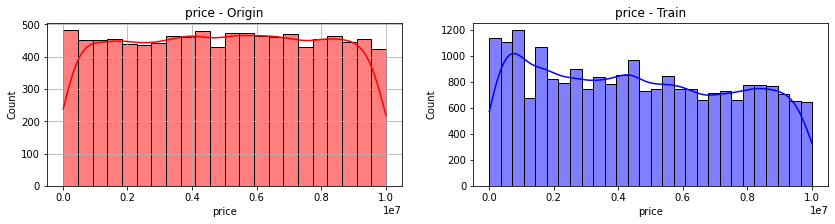

In [21]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.histplot(x=origin[target], color='r', kde=True)
plt.title(target + ' - Origin')
plt.grid()
ax2 = plt.subplot(1,2,2)
sns.histplot(x=train[target], color='b', kde=True)
plt.title(target + ' - Train')
plt.show()

# 가격대의 분포가 다양하는 것을 보아 여러 가격대가 있는 것으로 보인다.

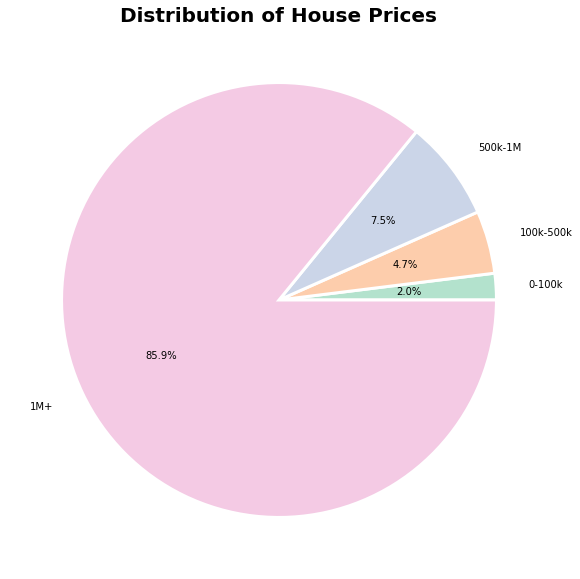

In [22]:
# 앞 선 histplot를 통해서 가격대를 10,50,100만대로 나눠서 확인

plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, train['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
train['price_range'] = pd.cut(train['price'], bins=bins, labels=labels)


plt.pie(train['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()

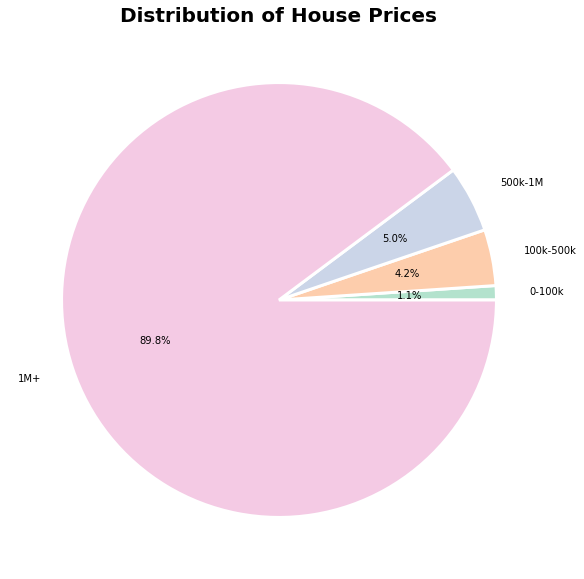

In [23]:
plt.figure(figsize=(15, 10))
bins = [0, 100000, 500000,1000000, origin['price'].max()]
labels = ['0-100k', '100k-500k','500k-1M', '1M+']
origin['price_range'] = pd.cut(origin['price'], bins=bins, labels=labels)


plt.pie(origin['price_range'].value_counts().sort_values(),autopct='%.1f%%',labels=labels,colors=sns.color_palette('Pastel2'),labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })

plt.title("Distribution of House Prices",fontdict={'fontweight':'bold','fontsize':20})

plt.show()
# 대부분 집값이 백만이상이다.

## Displot

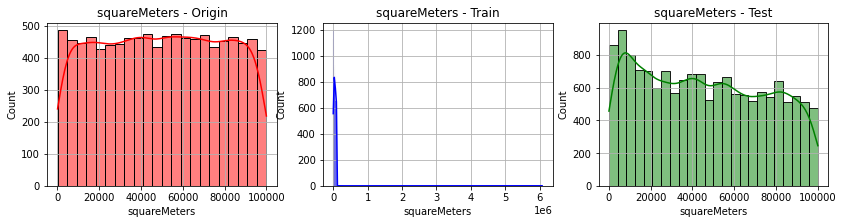

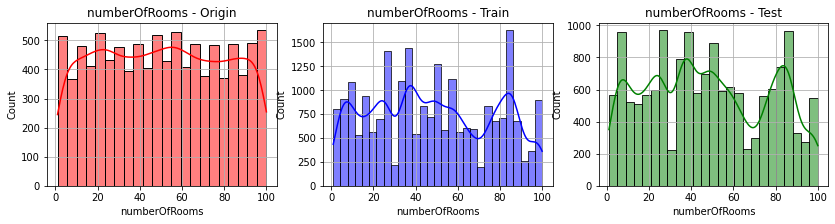

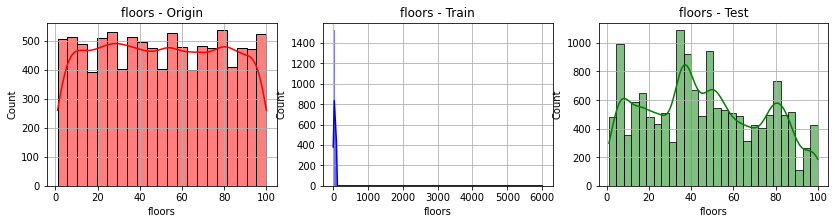

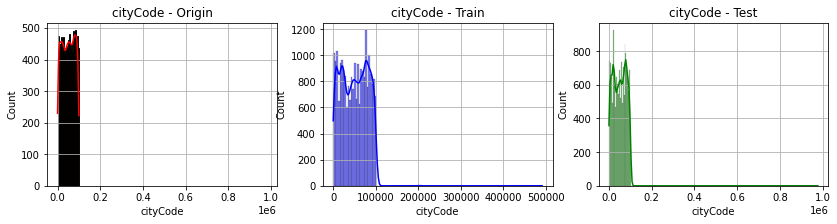

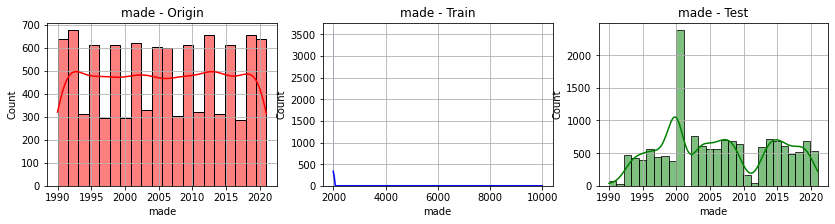

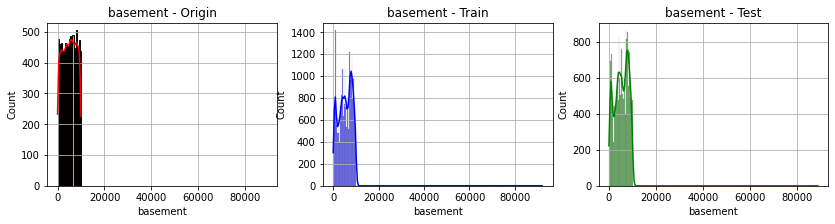

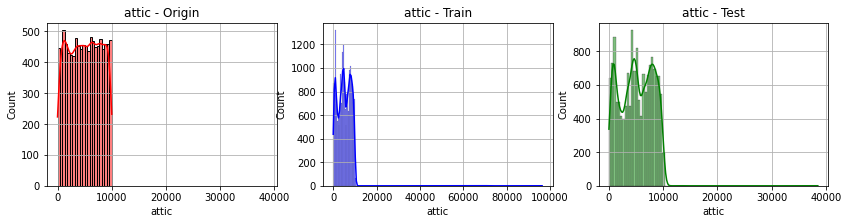

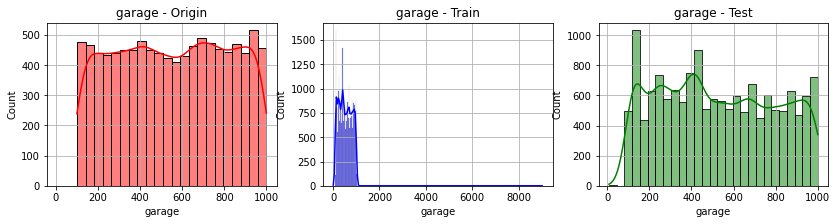

In [24]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 확인 시 train,test에서 비대칭(skewed) 데이터가 보인다. -> Skewed Data https://dining-developer.tistory.com/18

In [124]:
all_data = pd.concat([origin,train,test], ignore_index=True)

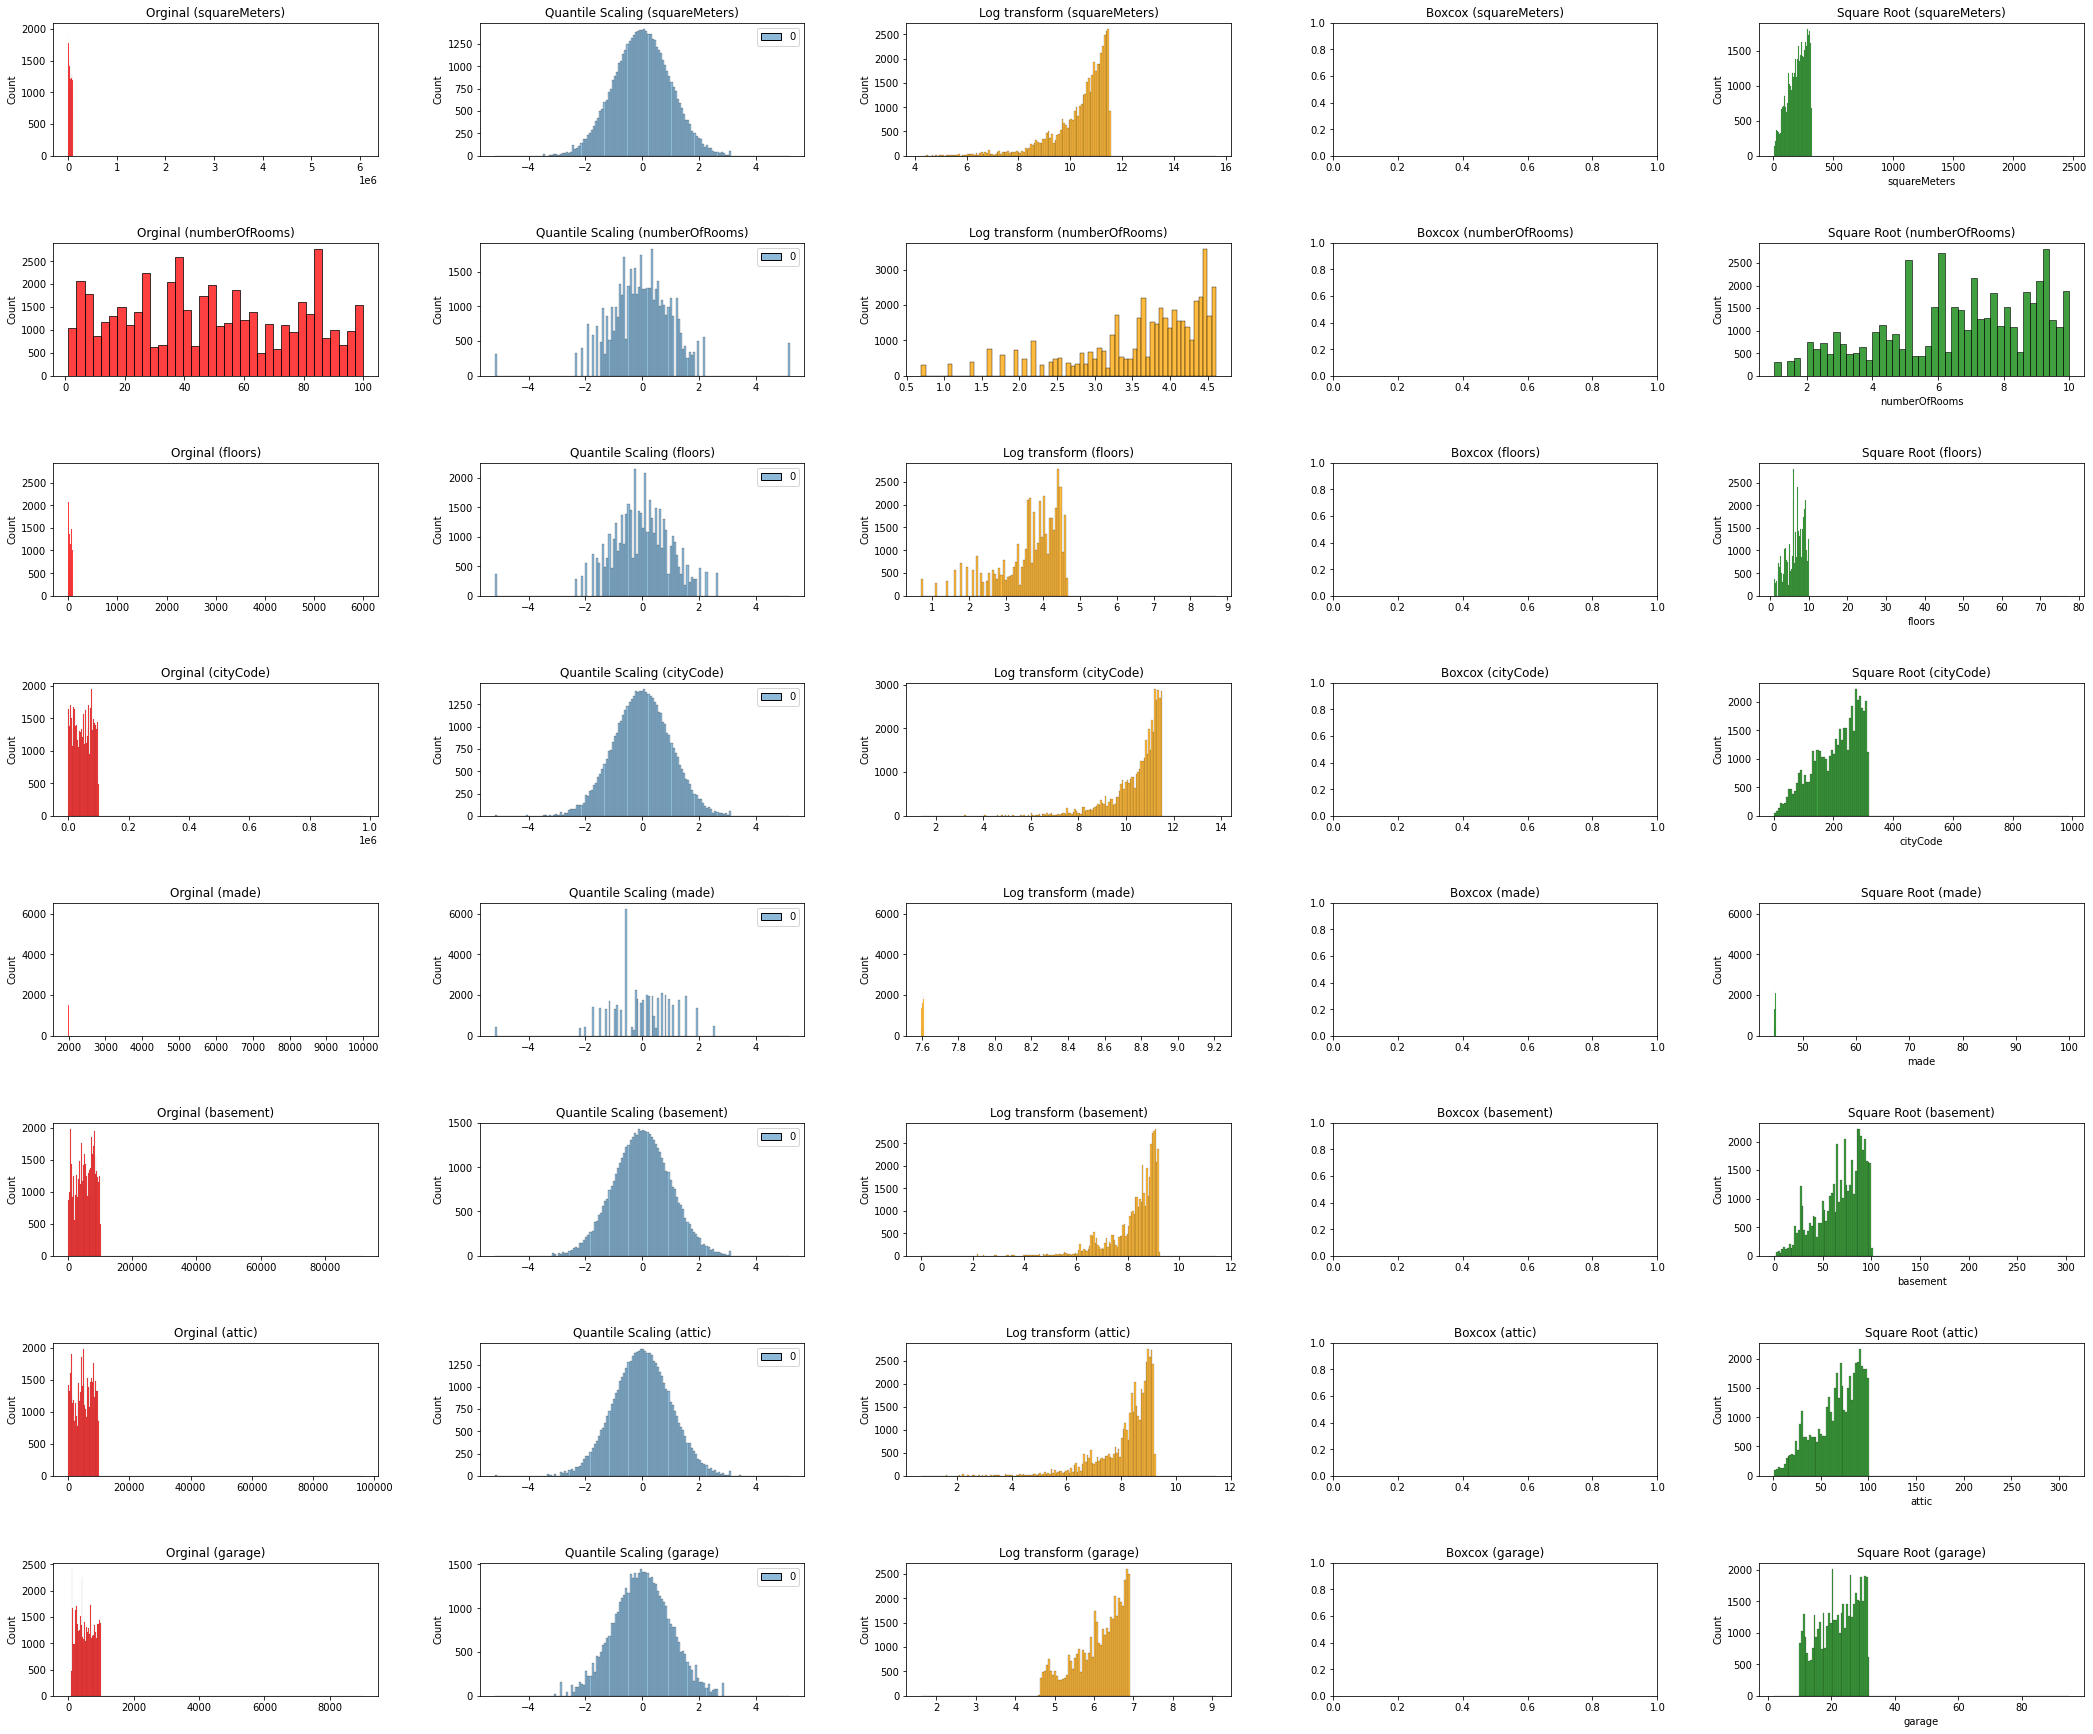

In [39]:
# 위에서 보인 비대칭 피처를 변환시키기 위해서는 어떤 방식으로 해야 될까
# 참고 : https://www.kaggle.com/code/slythe/1-eda-model-selection-pse3e6-regression

from scipy.stats import boxcox, median_abs_deviation 
from sklearn.preprocessing import QuantileTransformer

all_data = pd.concat([origin,train,test], ignore_index=True)

fig, axes = plt.subplots(len(features_cont),5, figsize = (30,25))

for i,col in enumerate(features_cont):
    scaler = QuantileTransformer(output_distribution="normal")
    quant_df = scaler.fit_transform(all_data[[col]])

    sns.histplot(x= all_data[col],ax= axes[i,0], color = "r")
    sns.histplot(quant_df,ax= axes[i,1] )
    sns.histplot(np.log1p(all_data[col]), ax = axes[i,2], color= "orange")

    try:
        sns.histplot(boxcox(all_data[col], 0.15)[0], ax = axes[i,3], color= "orange")

    except:
        pass

    sns.histplot(np.sqrt(all_data[col]), ax = axes[i,4], color= "green")

    axes[i,0].set_title(f"Orginal ({col})")
    axes[i,0].set(xlabel=None)
    axes[i,1].set_title(f"Quantile Scaling ({col})")
    axes[i,2].set_title(f"Log transform ({col})")
    axes[i,2].set(xlabel=None)
    axes[i,3].set_title(f"Boxcox ({col})")
    axes[i,4].set_title(f"Square Root ({col})")

plt.tight_layout(pad = 4)
plt.show()

# 확인 시 Quantile Scaling를 사용 시 정규분포 형태에 가까워 진다는 것을 알 수 있었다.

## Boxplot

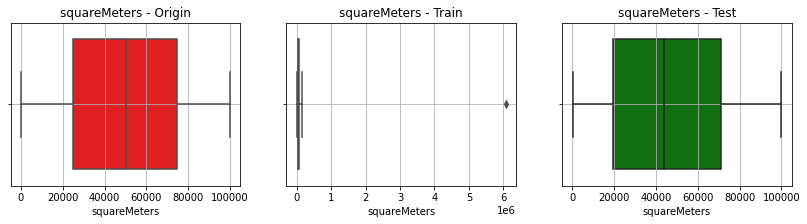

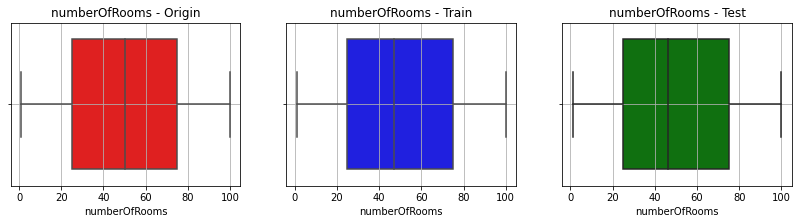

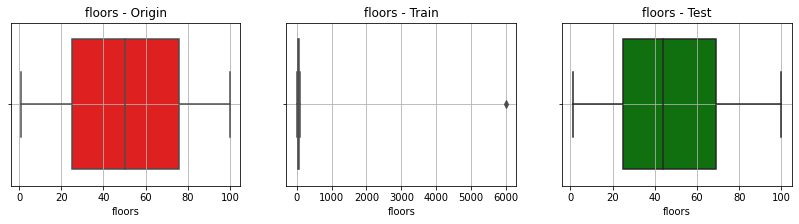

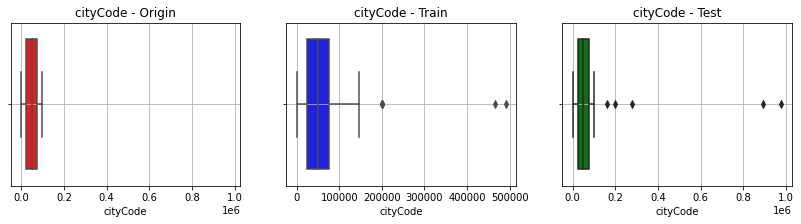

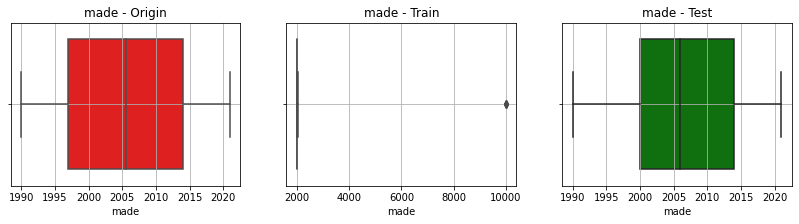

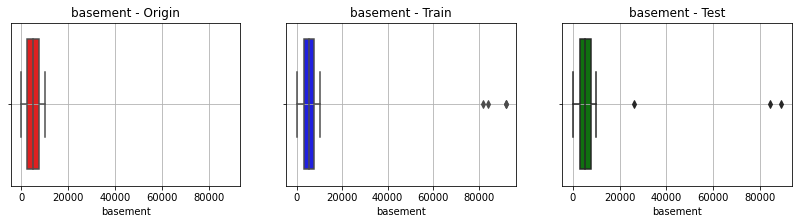

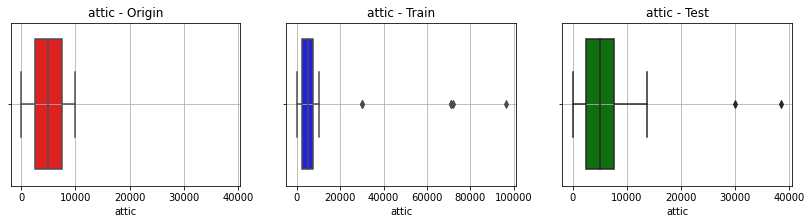

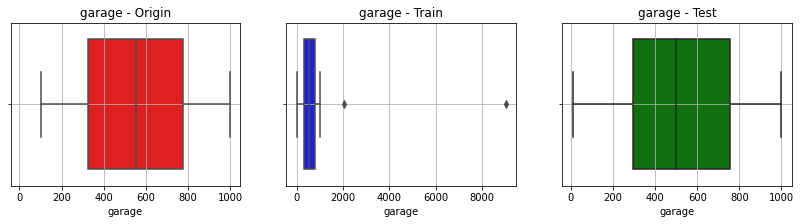

In [26]:
for f in features_cont:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3, sharex=ax1)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 원본에는 이상치 X, train/test이상치가 존재하는 것이 확인 -> squareMeter, floors, citycode, made, basement, attic, garage
# 다만 test 데이터 셋에서는 citycode, basement, attic 만 해당 됨 

## Countplot 

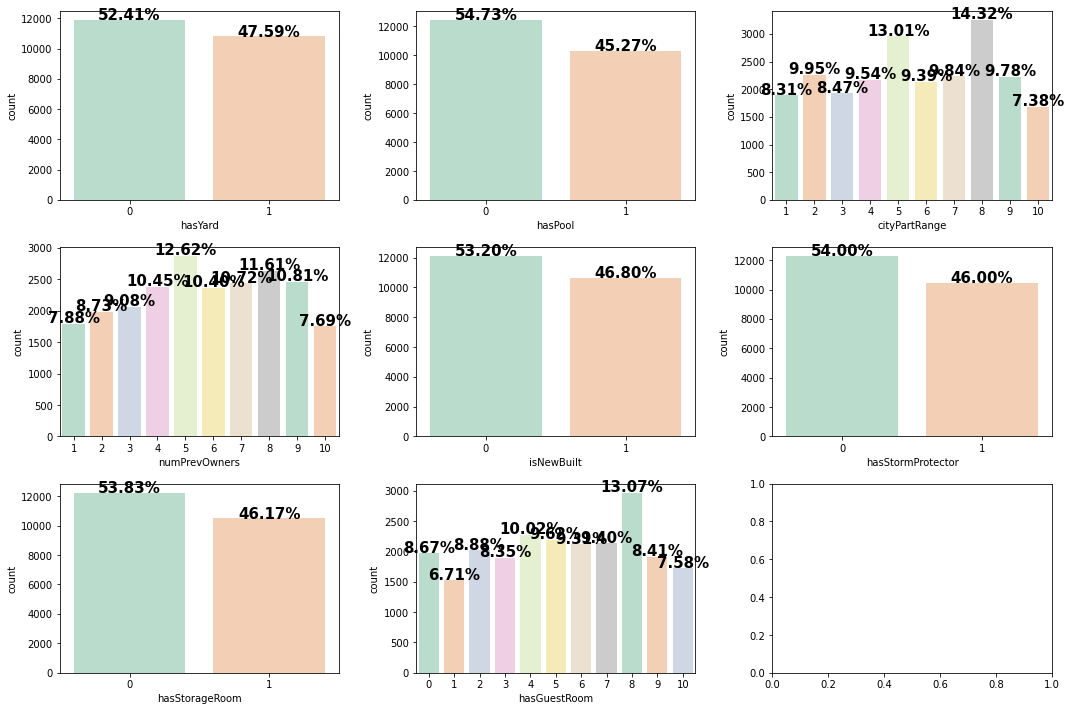

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()

for i, column in enumerate(features_cat):
    sns.countplot(x=train[column], ax=axes[i],palette='Pastel2')
    for j in axes[i].patches:
        height = j.get_height()
        axes[i].text(j.get_x() + j.get_width() / 2.,
                height + 20,
                '{:1.2f}%'.format(height / len(train) * 100),
                ha="center", fontsize=15,fontweight='bold')

plt.tight_layout()
plt.show()

## ScatterPlot

- **이상치 제거후 확인 시 선형관계 확인 가능**

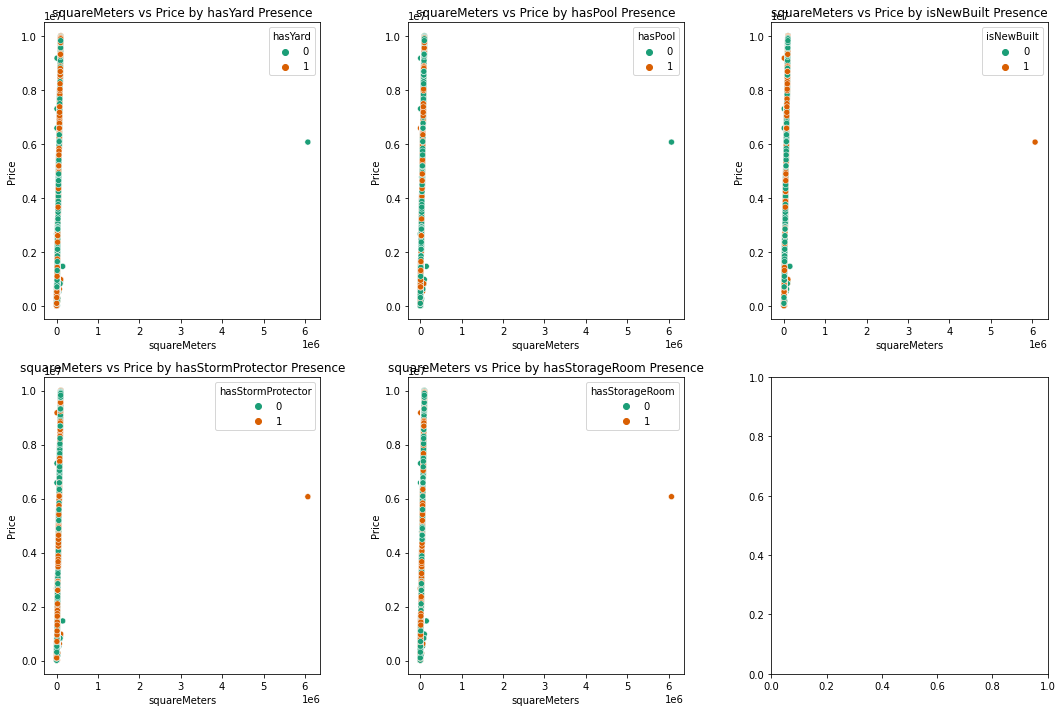

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axs = axs.ravel()

for i, column in enumerate(features_bin ):
    sns.scatterplot( x= train['squareMeters'], y=train['price'], hue = train[column], ax=axs[i],palette='Dark2')
    axs[i].set_title('squareMeters vs Price by '+ column +' Presence')
    axs[i].set_xlabel('squareMeters')
    axs[i].set_ylabel('Price')

plt.tight_layout()
plt.show()

## Regplot

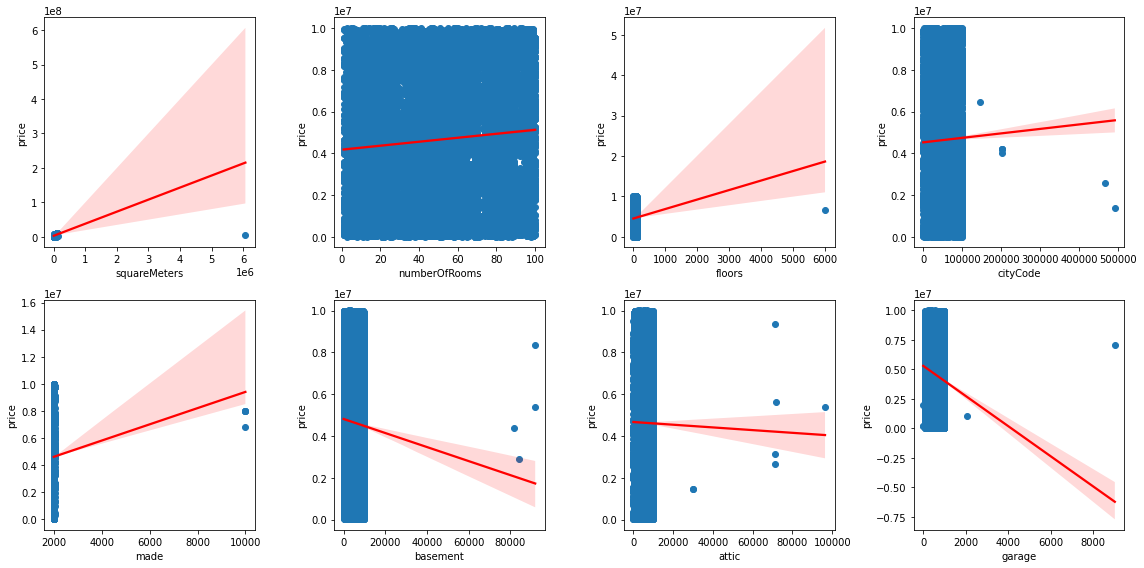

In [29]:
fig, axes = plt.subplots(figsize=(16,8), ncols=4, nrows=2)

for i, feature in enumerate(features_cont):
    row = int(i/4) 
    col = int(i%4)
    sns.regplot(x=feature,y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})

plt.tight_layout()
plt.show()

# 연속형 확인 시 squareMeters, floor, made가 어느정도 선형이 보임

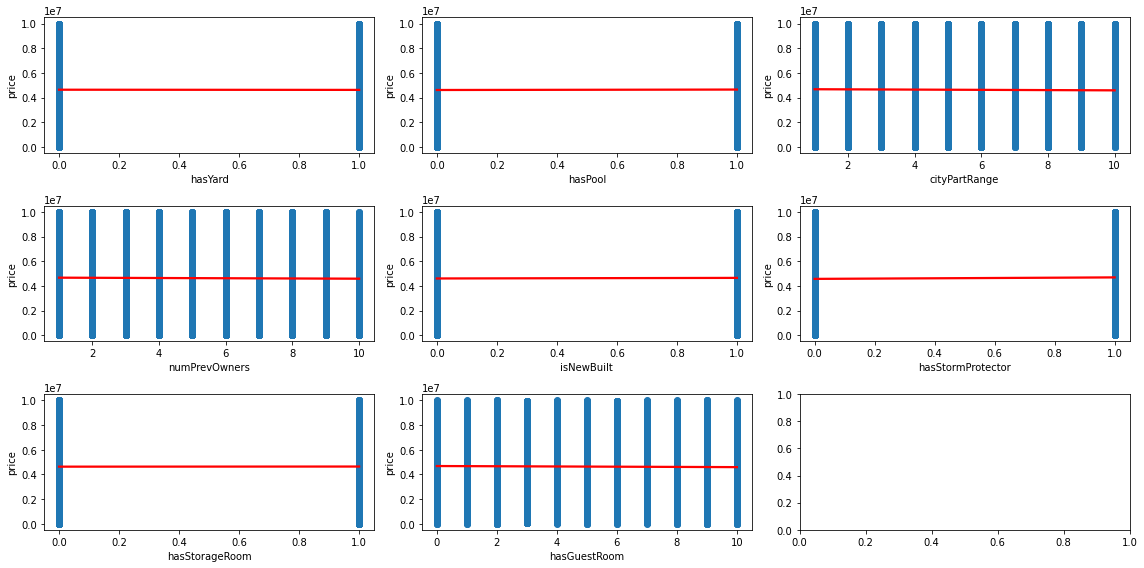

In [30]:
fig, axes = plt.subplots(figsize=(16,8), ncols=3, nrows=3)

for i, feature in enumerate(features_cat):
    row = int(i/3) 
    col = int(i%3)
    sns.regplot(x=feature, y='price',data=train, ax=axes[row][col], line_kws={'color':'red'}, scatter_kws={'alpha':1.0})
    
plt.tight_layout()
plt.show()

## Heatmap

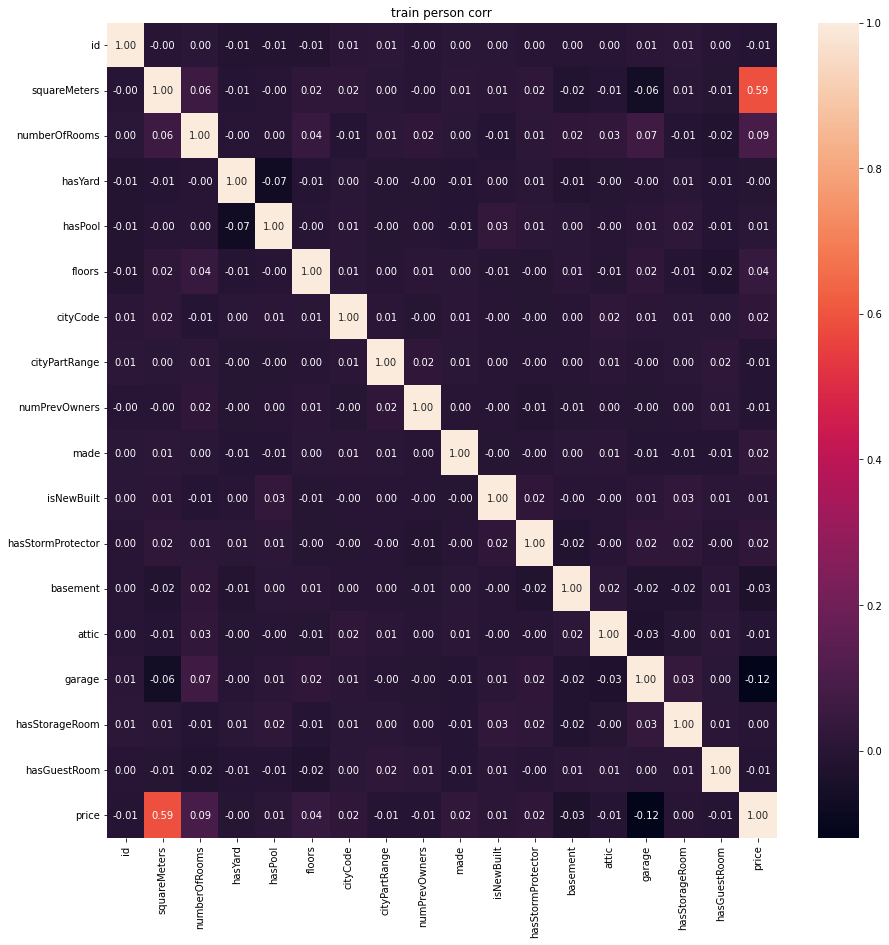

In [31]:
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# squareMeter를 제외하고 대부분 약한 상관관계를 가지고 있다.

# EDA 결과

- origin/train/test 데이터 셋에서는 결측치는 X 
- Boxplot 확인 시, train/test 데이터 셋에서 이상치는 다음과 같다 : squareMeters, floors, cityCode, made, basement, attic, garage는 
- Heatmap 확인 시 squaremeter 제외하고 다 약한 상관관계를 가지고 있다.
- Regplot 확인 시, basement, attic, garage는 price를 예측 시 도움이 되지 않는다

# 피처 엔지니어링

## 피쳐 제거 ( 선택 )

- 상관관계에서 가격 예측 시 필요한 특성만 사용하도록 하자

### citycode

In [ ]:
train = train.drop('cityCode', axis=1)
test = test.drop('cityCode', axis=1)
origin = origin.drop('cityCode', axis=1)

### made

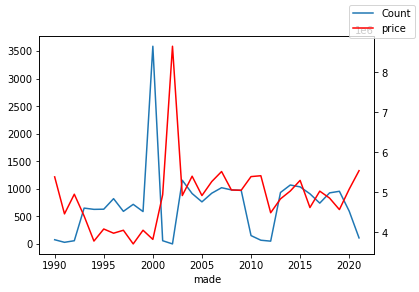

In [160]:
made = pd.DataFrame(train.groupby(['made']).size()).reset_index().rename(columns = {0:'Count'})
made = made[made['made']< 2022]

made1 = pd.DataFrame(train.groupby(['made'])['price'].mean()).reset_index().rename(columns = {0:'mean_price'})

made = pd.merge(made,made1, on = 'made', how = 'inner')

ax = made.plot(x="made", y="Count", legend=False)
ax2 = ax.twinx()
made.plot(x="made", y="price", ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.show()

In [127]:
made[made['made']<= 2000].corr()

,made,Count,price
made,1.000000,0.672256,-0.790501
Count,0.672256,1.000000,-0.486776
price,-0.790501,-0.486776,1.000000


In [128]:
made[made['made']> 2007].corr()

,made,Count,price
made,1.000000,0.025725,-0.069582
Count,0.025725,1.000000,-0.346971
price,-0.069582,-0.346971,1.000000


# 인코딩

In [130]:
# from sklearn.preprocessing import QuantileTransformer

# # price, made 제외하고 스케일링
# num_features = ['squareMeters', 'numberOfRooms', 'floors', 'basement', 'attic', 'garage' ]

# quantile = QuantileTransformer(output_distribution="normal")

# trans_all_data = all_data
# trans_all_data[num_features] = quantile.fit_transform(all_data[num_features])

In [118]:
# all_data.shape

(47884, 18)

In [119]:
# trans_all_data.shape

(47884, 18)

In [131]:
# # 정답의 결측여부로 해결
# train_origin = trans_all_data[~pd.isnull(trans_all_data['price'])] 
# test = trans_all_data[pd.isnull(trans_all_data['price'])] # submission용
# train_origin.shape, test.shape

((32730, 18), (15154, 18))

In [132]:
# train = train_origin[:len(train)]
# origin = train_origin[:len(origin)]

In [114]:
# origin.shape, train.shape, test.shape

((10000, 18), (22730, 18), (15154, 18))

In [163]:
train_1 = train[train['made']<=2000]
test_1 = test[test['made']<=2000]
train_2 = train[(train['made']>=2001) & (train['made']<=2007)]
test_2 = test[(test['made']>=2001) & (test['made']<=2007)]
train_3 = train[train['made']>2007]
test_3 = test[test['made']>2007]

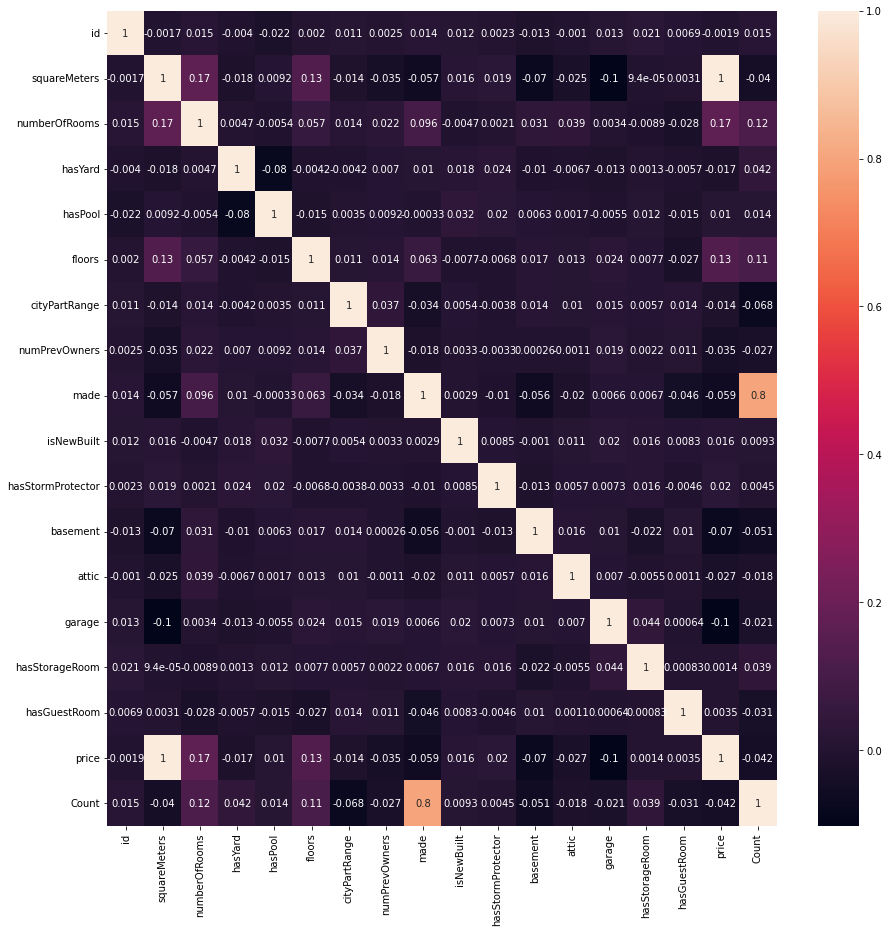

In [164]:
train_1 = pd.merge(train_1,made[['made','Count']], on = 'made', how = 'inner')
test_1 = pd.merge(test_1,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_1.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

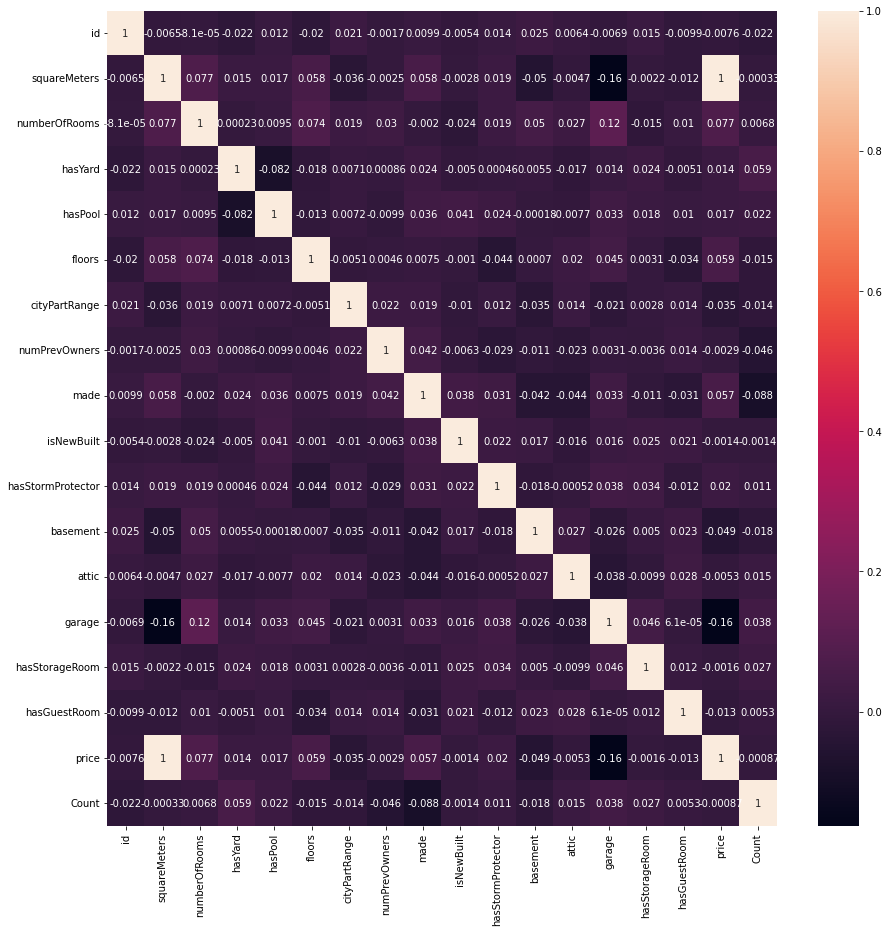

In [165]:
train_2 = pd.merge(train_2,made[['made','Count']], on = 'made', how = 'inner')
test_2 = pd.merge(test_2,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_2.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

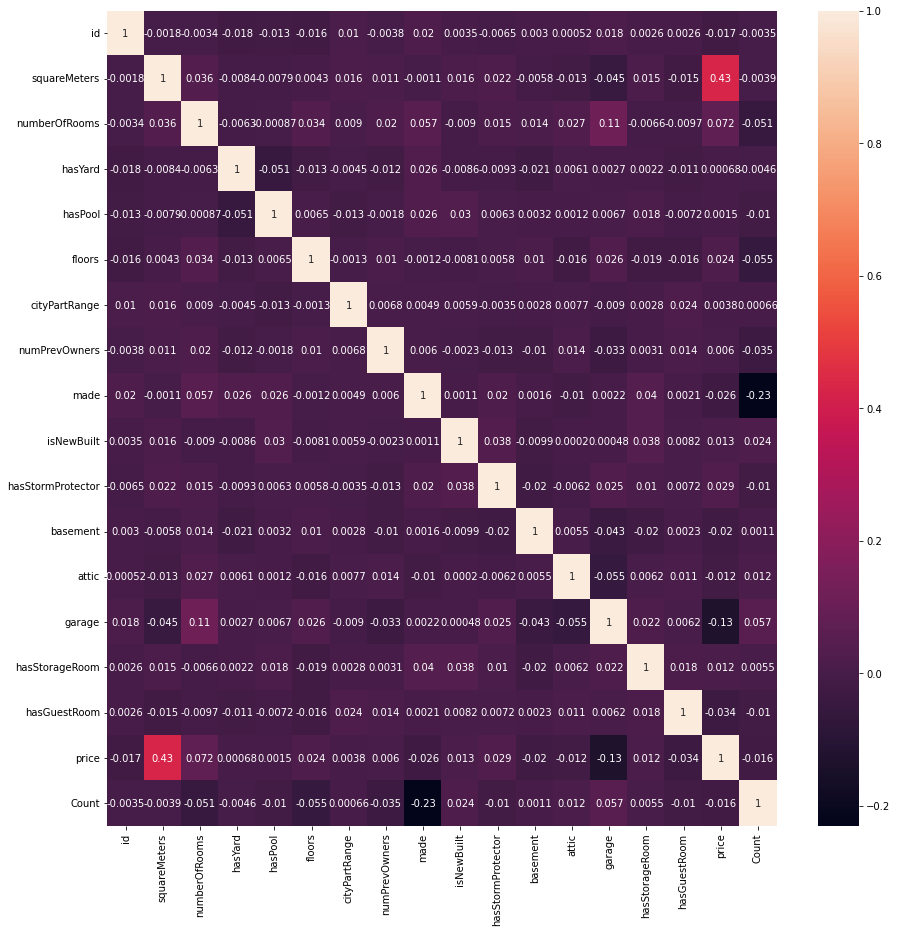

In [166]:
train_3 = pd.merge(train_3,made[['made','Count']], on = 'made', how = 'inner')
test_3 = pd.merge(test_3,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_3.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

In [141]:
# # 다시 made만 스케일링

# train_1['made'] = quantile.fit_transform(train_1[['made']])
# train_2['made'] = quantile.fit_transform(train_2[['made']])
# train_3['made'] = quantile.fit_transform(train_3[['made']])

# test_1['made'] = quantile.fit_transform(test_1[['made']])
# test_2['made'] = quantile.fit_transform(test_2[['made']])
# test_3['made'] = quantile.fit_transform(test_3[['made']])

In [167]:
num_features = num_features + ['Count']

In [170]:
X1 = train_1[num_features]
# X1 = train_1[['squareMeters']]
y1 = train_1['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X1,y1)


X_test = test_1[num_features]
# X_test = test_1[['squareMeters']]
prediction=XGB.predict(X_test)

test_1['price'] = prediction
test_1

ValueError: ignored

In [145]:
X2 = train_2[num_features]
# X2 = train_2[['squareMeters']]
y2 = train_2['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X2,y2)

X_test = test_2[num_features]
# X_test = test_2[['squareMeters']]
prediction=XGB.predict(X_test)

test_2['price'] = prediction
test_2

[07:55:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id,Count
0,0.607640,-0.248427,0,0,-1.220640,8824,8,3,-1.121060,0,1,0.911912,1.098262,-1.710968,0,3,6.963207e+06,22740.0,1156
1,-0.892038,-0.430727,0,0,-1.258508,95917,3,6,-1.121060,0,0,0.241640,0.198258,1.381364,1,6,1.532894e+06,22776.0,1156
2,-1.613483,-1.579968,1,0,0.979511,75722,3,8,-1.121060,0,0,-0.428369,-0.264409,1.152175,1,8,4.401388e+05,22868.0,1156
3,0.416580,1.194628,1,1,-0.385726,6769,2,3,-1.121060,1,0,0.792557,-0.666116,1.865852,0,10,6.214343e+06,22887.0,1156
4,1.477068,-1.887753,0,0,-0.325577,70160,8,3,-1.121060,1,1,0.297918,-0.635070,-1.805023,1,5,9.158890e+06,22907.0,1156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,0.725126,1.016672,0,0,-0.500651,55523,5,2,-5.199338,1,1,-0.261604,0.591221,-0.763030,1,9,7.392450e+06,36015.0,59
3226,1.383910,0.434861,1,1,-0.828465,16798,9,5,-5.199338,1,0,-0.307111,-0.681730,1.497997,1,3,9.017852e+06,36030.0,59
3227,-0.102410,-1.371657,0,0,0.509202,51294,7,9,-5.199338,1,0,0.858910,0.880888,-1.154615,0,8,4.181912e+06,36156.0,59
3228,0.249397,0.393847,1,1,1.533612,80933,3,4,-5.199338,1,1,2.309860,0.532190,0.069056,0,1,5.610711e+06,36298.0,59


In [146]:
X3 = train_3[num_features]
y3 = train_3['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X3,y3)

X_test = test_3[num_features]
prediction=XGB.predict(X_test)

test_3['price'] = prediction
test_3

[07:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id,Count
0,-0.838851,-0.005018,1,1,-1.307063,9262,6,5,1.090995,1,1,-1.579968,0.029696,-1.773922,1,5,1640336.750,22733.0,956
1,-0.270485,0.153660,1,1,-0.720087,40954,6,8,1.090995,1,0,1.023003,-0.197274,-0.085414,1,5,3551454.750,22748.0,956
2,1.131777,0.650274,0,1,-0.180377,92707,1,1,1.090995,0,1,-0.386701,0.062770,0.605955,1,0,8532260.000,22820.0,956
3,0.587132,0.650274,1,1,0.979511,72028,10,6,1.090995,0,1,2.074445,1.659878,0.961429,1,5,6886630.000,22826.0,956
4,-0.868554,-1.104747,1,1,-1.501861,95518,7,3,1.090995,1,1,-0.776770,1.080589,0.882753,1,5,1583032.375,22840.0,956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,0.218083,-0.248427,1,1,0.886449,5324,8,6,-0.736442,0,1,0.923222,0.870513,-2.004234,1,8,5463507.000,36857.0,68
6331,0.218083,-0.676854,1,0,1.674186,8235,4,5,-0.736442,0,1,0.858910,1.242061,-0.914679,0,6,5453981.500,37118.0,68
6332,-0.462060,1.016672,1,0,1.674186,86189,5,9,-0.736442,1,1,1.066304,1.482760,-0.886449,1,1,2660693.750,37278.0,68
6333,0.819656,1.093272,0,1,1.475269,1529,5,4,-0.736442,0,0,1.171381,0.877933,0.163824,1,0,7701268.500,37431.0,68


In [150]:
submission = pd.concat([test_1,test_2,test_3])
submission = submission[['id','price']]
submission = submission.sort_values(by = ['id'])
submission = submission.astype({'id':'string'})
submission.to_csv('submission.csv',index = False)
submission.head()
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15154 entries, 0 to 2630
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      15154 non-null  string 
 1   price   15154 non-null  float32
dtypes: float32(1), string(1)
memory usage: 296.0 KB
